# Non-regular Optimal Points

In this tutorial we explore strategies for dealing with non-regular optimal points, i.e., points where the first-order derivatives of the equality constraints and (active) inequality constraints are linearly dependent or when the number of active constraints exceeds the dimensionality of the output. In the former, the KKT conditions may still be satisfied but there are degrees of freedom in the Lagrange multipliers. In the latter, the system is overdetermined.

Our examples are based on finding the nearest point to $x$ to some convex set defined by quadratic and affine inequality constraints, which has general form

$$
\begin{array}{lll}
    \text{minimize}_u & \frac{1}{2} \|u - x\|^2 \\
    \text{subject to} & u^T P_i u + q_i^Tu + r_i \leq 0, & i = 1, \ldots, p
\end{array}
$$

where $P_i$ may be zero (to give an affine constraint).

These problems fall under the banner of so-called quadratically constrained quadratic programs (QCQPs). They do not have closed-form solutions but are convex and can be solved efficiently. Here we use `scipy.optimize.minimize`, which is not necessarily the best QCQP solver but available in most Python installations. Try [cvxpy](https://www.cvxpy.org/) for better convex program optimizers.

To keep things simple we restrict the problems to $\mathbb{R}^2$ and hold the first input dimension fixed at $x_1 = 2$ while sweeping over the second input dimension in the range $-4 \leq x_2 \leq 4$. Visualizations show the individual constraint functions for each problem as overlapping shaded regions; the darkest region defining the constraint set.

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import scipy.optimize as opt

from matplotlib.patches import Circle, Ellipse, Rectangle, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')

eps = 1.0e-6 # precision for determining active constraints

## Example 1: Overdetermined

The first example constrains the solution to a circle with two segments removed. We formulate this as the intersection of a (solid) circle constraint with two half-spaces,

$$
\begin{array}{lll}
    y \in & \text{argmin}_u & \frac{1}{2} \|u - x\|^2 \\
    & \text{subject to} & u_1^2 + u_2^2 - 1 \leq 0 \\
    & & u_1 - u_2 - 1 \leq 0 \\
    & & u_1 + u_2 - 1 \leq 0
\end{array}
$$

Below we visualize the constraint set. We also show the solution $y \in \mathbb{R}^2$ as a function of $x = (2, x_2)$ where $x_2$ is swept from -4 to 4. When $x_2$ is in the range $[-1, 1]$ all three constraints are active. This results in an overdetermined system of equations for computing $\text{D} y(x)$ as we show below.

<IPython.core.display.Javascript object>


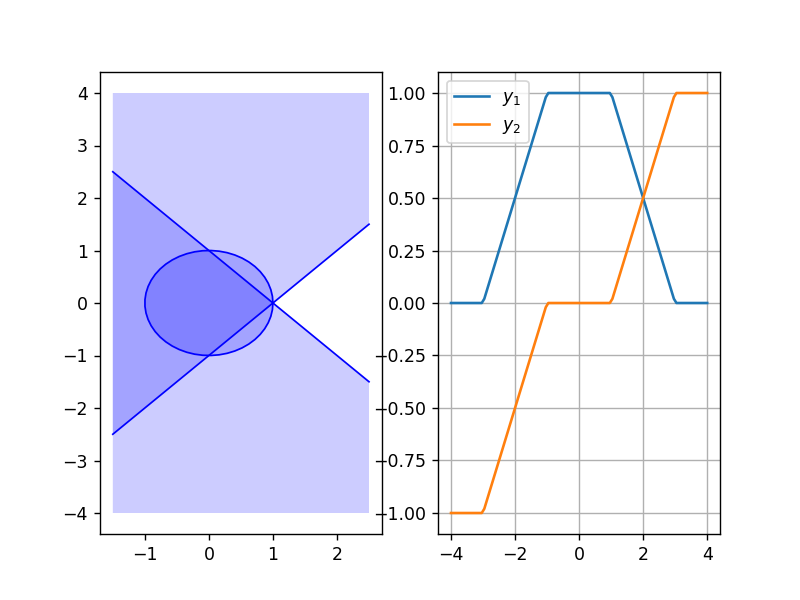

In [3]:
# visualize constraints
u1 = np.linspace(-1.5, 2.5)
t = np.linspace(0.0, 2.0 * np.pi)

patches = []
patches.append(Circle((0, 0), 1.0)) # h1
patches.append(Polygon([(-1.5, 2.5), (2.5, -1.5), (2.5, -4.0), (-1.5, -4.0)], True)) # h2
patches.append(Polygon([(-1.5, -2.5), (2.5, 1.5), (2.5, 4.0), (-1.5, 4.0)], True)) # h3

plt.figure()
plt.subplot(1, 2, 1)
p = PatchCollection(patches, alpha=0.2)
p.set_facecolor('b')
plt.gca().add_collection(p)
plt.plot(np.cos(t), np.sin(t), 'b-', linewidth=1)
plt.plot(u1, 1.0 - u1, 'b-', linewidth=1)
plt.plot(u1, -1.0 + u1, 'b-', linewidth=1)

# define inequality constraints as h_i >= 0 to use scipy.optimize.minimize function
h1 = lambda u: -1.0 * (u[0]**2 + u[1]**2 - 1.0)
h2 = lambda u: -u[0] + u[1] + 1.0
h3 = lambda u: -u[0] - u[1] + 1.0

# solve a bunch of problems varying x_2
x1 = 2.0
x2 = np.linspace(-4.0, 4.0, 101)
y = []
for xi in x2:
    # minimize the square distance to (2, xi) subject to constraints
    result = opt.minimize(lambda u: (u[0] - x1)**2 + (u[1] - xi)**2, (0.0, 0.0), options={'maxiter': 100, 'disp': False},
        constraints=({'type': 'ineq', 'fun': h1}, {'type': 'ineq', 'fun': h2}, {'type': 'ineq', 'fun': h3}))
    y.append(result.x)

# visualize optimal solution
plt.subplot(1, 2, 2)
plt.plot(x2, [yi[0] for yi in y])
plt.plot(x2, [yi[1] for yi in y])
plt.grid()
plt.legend([r"$y_1$", r"$y_2$"])
plt.show()

We now animate moving the input $x$ and show the corresponding output $y(x)$. Note that the axes are not square (which is why the output may not appear visually to be the closest point in the feasible set). You can remove the comment `#` in front of the statement `ax.axis('square')` to force square axes.

In [4]:
%%capture

def animate(fnum, x, y):

    # draw constraints
    ax.clear()
    p = PatchCollection(patches, alpha=0.2)
    p.set_facecolor('b')
    ax.add_collection(p)
    ax.plot(np.cos(t), np.sin(t), 'b-', linewidth=1)
    ax.plot(u1, 1.0 - u1, 'b-', linewidth=1)
    ax.plot(u1, -1.0 + u1, 'b-', linewidth=1)
    
    # draw x and y
    ax.plot(x1, x[fnum], 'ko')
    ax.plot(y[fnum][0], y[fnum][1], 'bo')
    ax.plot([x1, y[fnum][0]], [x[fnum], y[fnum][1]], 'b--')
    
    # count active constraints
    num_active = 0
    if h1(y[fnum]) < eps: num_active += 1
    if h2(y[fnum]) < eps: num_active += 1
    if h3(y[fnum]) < eps: num_active += 1
    ax.text(-0.95, 3.5, "{} active constraint(s)".format(num_active))
    
    #ax.axis('square')
    ax.set_xlim(-1.0, 2.5); ax.set_ylim(x[0], x[-1])
    return (ax,)

# animate
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
ani = animation.FuncAnimation(fig, animate, init_func=None, fargs=(x2, y),
                              interval=100, frames=len(x2), blit=False, repeat=False)
plt.close(fig)

In [5]:
#HTML(ani.to_jshtml())
HTML(ani.to_html5_video())

### Gradient Calculations

The gradient calculation involves implicit differentiation of the KKT optimality conditions as discussed in ["Deep Declarative Networks: A New Hope"](https://arxiv.org/abs/1909.04866). Here we are required to solve

$$
\begin{bmatrix} H & -A^T \\ A & 0 \end{bmatrix}
\begin{bmatrix} \text{D}y \\ \text{D}\lambda \end{bmatrix}
+
\begin{bmatrix} B \\ C \end{bmatrix}
= 0
$$

with the following quantities

$$
\begin{array}{llll}
    A &= \text{D}_{Y} h(y) &= \begin{bmatrix}
         2 y_1 & 2 y_2 \\ 1 & -1 \\ 1 & 1
         \end{bmatrix} & \text{for active $h_i$} \\
    B &= \text{D}^2_{XY} f(x, y) - \sum_{i=1}^{3} \lambda_i \text{D}^2_{XY} h_i(y) &= -I \\
    C &= \text{D}_{X} h(y) &= 0 \\
    H &= \text{D}^2_{YY} f(x, y) - \sum_{i=1}^{3} \lambda_i \text{D}^2_{YY} h_i(y) &= (1 - 2 \lambda_1) I 
\end{array}
$$

where inactive constraints, and corresponding Lagrange multipliers, are first removed (i.e., $A$ may have between zero and three rows). The equations can be solved to give

$$
\text{D} y(x) = \begin{cases}
        I & \text{if all constraints are inactive} \\
        0 & \text{if all constraints are active (since $C = 0$)} \\
        I - A^T (AA^T)^{-1} A & \text{if $h_1$ is inactive} \\
        \frac{1}{1 - 2 \lambda_1} \left(I - A^T (AA^T)^{-1} A\right) & \text{otherwise}
    \end{cases}
$$

<IPython.core.display.Javascript object>


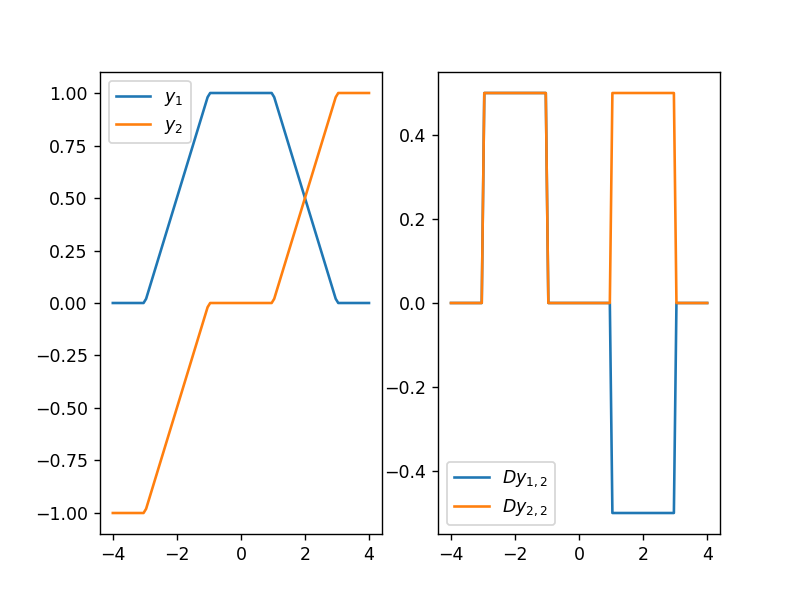

In [6]:
def gradient(x, y):
    # compute D_Y f(x, y)
    g = (y - x).T
    
    # compute A, B, C and H; only add to A if h_i are active
    A = []
    if h1(y) < eps: A.append(2.0 * y.T)
    if h2(y) < eps: A.append([1, -1])
    if h3(y) < eps: A.append([1, 1])
    A = np.array(A)
    
    # check for all constraints inactive
    if (A.shape[0] == 0):
        return np.identity(2)
    
    # check for overdetermined
    if (A.shape[0] == 3):
        return np.zeros((2, 2)) # equivalent to np.linalg.lstsq(A, np.zeros((3, 2)))[0]
    
    # check if lambda_1 is needed
    lmda1 = 0.0
    if h1(y) < eps:
        nu = np.linalg.solve(A.T, g)
        lmda1 = nu[0]

    Dy = np.identity(2) - np.dot(np.dot(A.T, np.linalg.inv(np.dot(A, A.T))), A)
    return 1.0 / (1.0 - 2.0 * lmda1) * Dy

dydx = []
for xi, yi in zip(x2, y):
    Dy = gradient((x1, xi), yi)
    dydx.append(Dy[1, :])
    
# plot y and Dy
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(x2, [yi[0] for yi in y])
plt.plot(x2, [yi[1] for yi in y])
plt.legend([r"$y_1$", r"$y_2$"])

plt.subplot(1, 2, 2)
plt.plot(x2, [di[0] for di in dydx])
plt.plot(x2, [di[1] for di in dydx])
plt.legend([r"$D y_{1,2}$", r"$D y_{2,2}$"])
plt.show()

## Example 2: Rank Deficient

In this second example the constraint set is defined as the intersection between a circle and an ellipse,

$$
\begin{array}{llll}
    y \in & \text{argmin}_u & \frac{1}{2} \|u - x\|^2 \\
    & \text{subject to} & u_1^2 + u_2^2 - 1 \leq 0 & (h_1) \\
    & & \frac{1}{4}(u_1 + 1)^2 + 4 u_2^2 - 1 \leq 0 & (h_2)
\end{array}
$$

Again we visualize the constraint set and show the solution $y \in \mathbb{R}^2$ as a function of $x = (2, x_2)$ where $x_2$ is swept from -4 to 4. At $x_2 = 0$ both constraints are active. This results in $A$ being rank deficient.

<IPython.core.display.Javascript object>


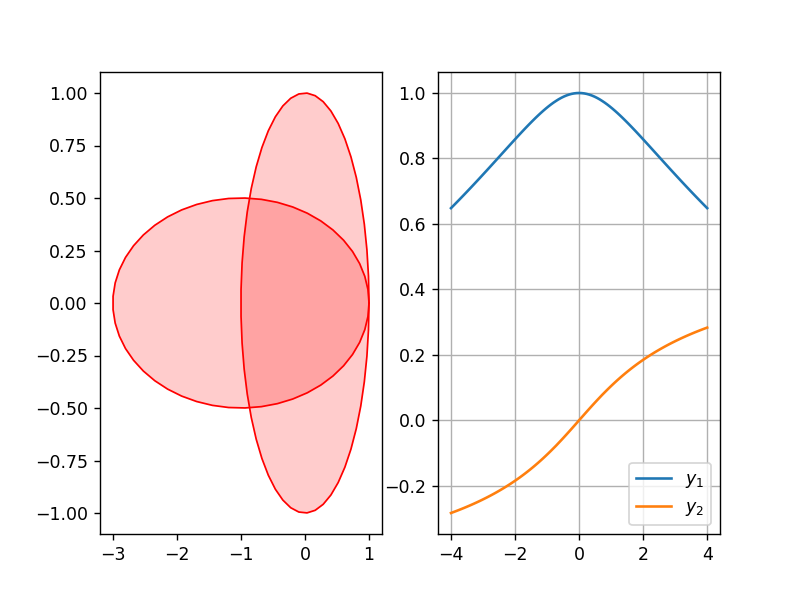

In [7]:
# visualize constraints
u1 = np.linspace(-1.0, 2.0)
t = np.linspace(0.0, 2.0 * np.pi)

patches = []
patches.append(Circle((0, 0), 1.0)) # h1
patches.append(Ellipse((-1, 0), 4.0, 1.0)) # h2

plt.figure()
plt.subplot(1, 2, 1)
p = PatchCollection(patches, alpha=0.2)
p.set_facecolor('r')
plt.gca().add_collection(p)
plt.plot(np.cos(t), np.sin(t), 'r-', linewidth=1)
plt.plot(2.0 * np.cos(t) - 1.0, 0.5 * np.sin(t), 'r-', linewidth=1)

# define inequality constraints as h_i >= 0 to use scipy.optimize.minimize function
h1 = lambda u: -1.0 * (u[0]**2 + u[1]**2 - 1.0)
h2 = lambda u: -1.0 * (0.25 * (u[0] + 1.0)**2 + 4.0 * u[1]**2 - 1.0)

# solve a bunch of problems varying x_2
x1 = 2.0
x2 = np.linspace(-4.0, 4.0, 101)
y = []
for xi in x2:
    # minimize the square distance to (2, xi) subject to constraints
    result = opt.minimize(lambda u: (u[0] - x1)**2 + (u[1] - xi)**2, (0.0, 0.0), options={'maxiter': 100, 'disp': False},
        constraints=({'type': 'ineq', 'fun': h1}, {'type': 'ineq', 'fun': h2}))
    y.append(result.x)

# visualize optimal solution
plt.subplot(1, 2, 2)
plt.plot(x2, [yi[0] for yi in y])
plt.plot(x2, [yi[1] for yi in y])
plt.grid()
plt.legend([r"$y_1$", r"$y_2$"])
plt.show()

In [8]:
%%capture

def animate(fnum, x, y):

    # draw constraints
    ax.clear()
    p = PatchCollection(patches, alpha=0.2)
    p.set_facecolor('r')
    ax.add_collection(p)
    ax.plot(np.cos(t), np.sin(t), 'r-', linewidth=1)
    ax.plot(2.0 * np.cos(t) - 1.0, 0.5 * np.sin(t), 'r-', linewidth=1)
    
    # draw x and y
    ax.plot(x1, x[fnum], 'ko')
    ax.plot(y[fnum][0], y[fnum][1], 'ro')
    ax.plot([x1, y[fnum][0]], [x[fnum], y[fnum][1]], 'r--')

    # count active constraints
    num_active = 0
    if h1(y[fnum]) < eps: num_active += 1
    if h2(y[fnum]) < eps: num_active += 1
    ax.text(-2.95, 3.5, "{} active constraint(s)".format(num_active))    
    
    #ax.axis('square')
    ax.set_xlim(-3.0, 2.5); ax.set_ylim(x[0], x[-1])
    return (ax,)

# animate
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
ani = animation.FuncAnimation(fig, animate, init_func=None, fargs=(x2, y),
                              interval=100, frames=len(x2), blit=False, repeat=False)
plt.close(fig)

In [9]:
#HTML(ani.to_jshtml())
HTML(ani.to_html5_video())

### Gradient Calculations

As for the previous example the quantities needed for determing $\text{D}y(x)$ are

$$
\begin{array}{lll}
    A &= \begin{bmatrix}
         2y_1 & 2 y_2 \\ \frac{1}{2} (y_1 + 1) & 8 y_2
         \end{bmatrix} & \text{for active $h_i$} \\
    B &= -I \\
    C &= 0 \\
    H &= \begin{bmatrix}
         1 - 2 \lambda_1 - \frac{1}{2} \lambda_2 & 0 \\
         0 & 1 - 2 \lambda_1 - 8 \lambda_2
         \end{bmatrix}
\end{array}
$$

At $y = (1, 0)$ the matrix $A$ is rank deficient, which occurs for any point $(x_1 \geq 1, 0)$. Here we need to remove one of the rows of $A$ before solving for $\text{D}y$. A good rule of thumb is to keep those constraints where the rate of change of the objective is steepest relative to the curvature induced by the constraint surface. That is, remove from $A$ rows that are linearly dependent on other rows and with the smaller $\text{D}_{Y}f (\text{D}_{YY}^2 h_i)^{-1} \text{D}_{Y}f^T$.

<IPython.core.display.Javascript object>


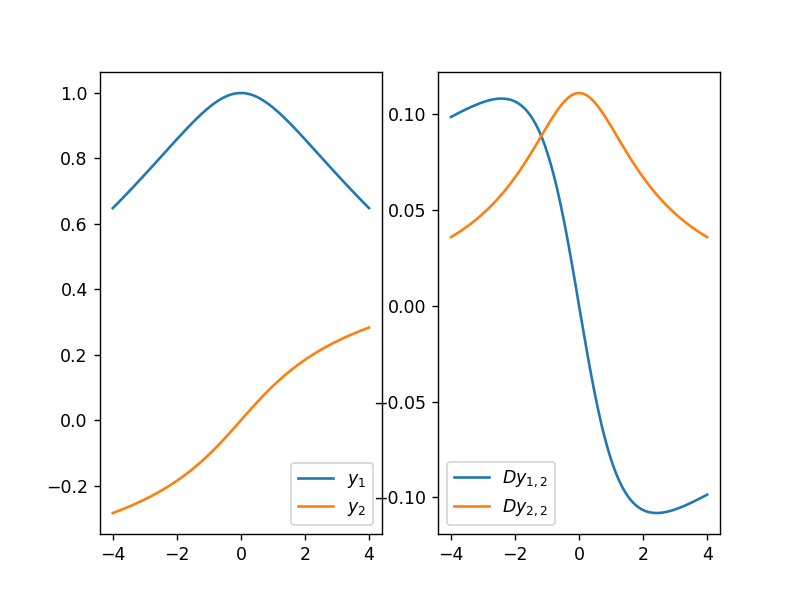

In [10]:
def gradient(x, y):
    # compute D_Y f(x, y)
    g = (y - x).T
    
    def Dy_for_h1_active():
        A = 2.0 * y.T
        lmda1 = g[0] / A[0]
        Dy = np.identity(2) - np.outer(A.T, A) / np.dot(A, A.T)
        return 1.0 / (1.0 - 2.0 * lmda1) * Dy
    
    def Dy_for_h2_active():
        A = np.array([0.5 * (y[0] + 1.0), 8.0 * y[1]])
        lmda2 = g[0] / A[0]
        invH = np.array([[1.0 / (1.0 - 0.5 * lmda2), 0.0], [0.0, 1.0 / (1.0 - 8.0 * lmda2)]])
        Dy = -1.0 * np.outer(np.dot(invH, A), np.dot(A.T, invH)) / np.dot(A.T, np.dot(invH, A)) + invH
        return Dy
    
    # compute gradient depending on which constraints are active
    if h1(y) < eps and h2(y) < eps:
        h1_YY = 2.0 * np.identity(2)
        h2_YY = np.array([[0.5, 0.0], [0.0, 8.0]])
        v1 = np.dot(np.linalg.solve(h1_YY, g), g)
        v2 = np.dot(np.linalg.solve(h2_YY, g), g)
        if v1 > v2:
            return Dy_for_h1_active()
        else:
            return Dy_for_h2_active()
    
    if h1(y) < eps:
        return Dy_for_h1_active()
        
    if h2(y) < eps:
        return Dy_for_h2_active()
    
    # no active constraints
    return np.identity(2)


dydx = []
for xi, yi in zip(x2, y):
    Dy = gradient((x1, xi), yi)
    dydx.append(Dy[1, :])
    
# plot y and Dy
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(x2, [yi[0] for yi in y])
plt.plot(x2, [yi[1] for yi in y])
plt.legend([r"$y_1$", r"$y_2$"])

plt.subplot(1, 2, 2)
# computed gradient
plt.plot(x2, [di[0] for di in dydx])
plt.plot(x2, [di[1] for di in dydx])
# check against empirical gradient
#plt.plot(x2, np.gradient([yi[0] for yi in y], (x2[-1] - x2[0]) / (len(x2) - 1)))
#plt.plot(x2, np.gradient([yi[1] for yi in y], (x2[-1] - x2[0]) / (len(x2) - 1)))
plt.legend([r"$D y_{1,2}$", r"$D y_{2,2}$", r"$D^\star y_{1,2}$", r"$D^\star y_{2,2}$"])
plt.show()

## Example 3: A Non-Convex Case

Here is another example that results in rank deficiency. However now the constraint set is defined as the area in the circle that is not within the ellipse,

$$
\begin{array}{llll}
    y \in & \text{argmin}_u & \frac{1}{2} \|u - x\|^2 \\
    & \text{subject to} & u_1^2 + u_2^2 - 1 \leq 0 & (h_1) \\
    & & \frac{1}{4}(u_1 + 1)^2 + 4 u_2^2 - 1 \geq 0 & (h_2)
\end{array}
$$

which is a non-convex optimization problem. (Note the change in sign for the second inequality constraint).

Unlike the last examples we now fix $x_1 = 0.75$. The active constraints switch as $x_2$ is swept from -4 to 4. At $x = (0.75, 0)$ we get $y = (1, 0)$ and both constraints are active, resulting in $A$ being rank deficient.

<IPython.core.display.Javascript object>


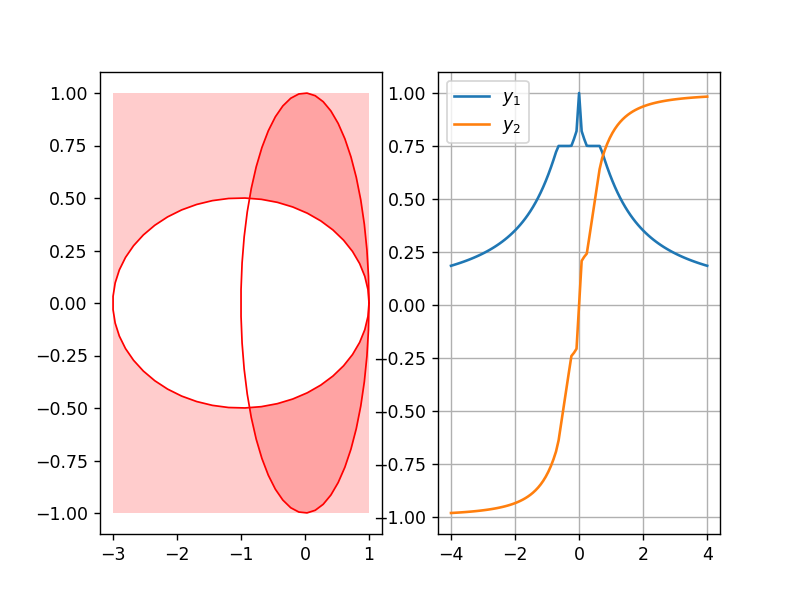

In [11]:
# visualize constraints
u1 = np.linspace(-1.0, 2.0)
t = np.linspace(0.0, 2.0 * np.pi)

plt.figure()
plt.subplot(1, 2, 1)
plt.gca().add_patch(Circle((0, 0), 1.0, facecolor='r', alpha=0.2)) # h1
plt.gca().add_patch(Rectangle((-3, -1), 4.0, 2.0, facecolor='r', alpha=0.2)) #h2
plt.gca().add_patch(Ellipse((-1, 0), 4.0, 1.0, facecolor='w', alpha=1.0)) #h2
plt.plot(np.cos(t), np.sin(t), 'r-', linewidth=1)
plt.plot(2.0 * np.cos(t) - 1.0, 0.5 * np.sin(t), 'r-', linewidth=1)

# define inequality constraints as h_i >= 0 to use scipy.optimize.minimize function
h1 = lambda u: -1.0 * (u[0]**2 + u[1]**2 - 1.0)
h2 = lambda u: 0.25 * (u[0] + 1.0)**2 + 4.0 * u[1]**2 - 1.0

# solve a bunch of problems varying x_2
x1 = 0.75
x2 = np.linspace(-4.0, 4.0, 101)
y = []
for xi in x2:
    # minimize the square distance to (0.75, xi) subject to constraints
    result = opt.minimize(lambda u: (u[0] - x1)**2 + (u[1] - xi)**2, (x1, xi), options={'maxiter': 100, 'disp': False},
        constraints=({'type': 'ineq', 'fun': h1}, {'type': 'ineq', 'fun': h2}))
    y.append(result.x)

# visualize optimal solution
plt.subplot(1, 2, 2)
plt.plot(x2, [yi[0] for yi in y])
plt.plot(x2, [yi[1] for yi in y])
plt.grid()
plt.legend([r"$y_1$", r"$y_2$"])
plt.show()

In [12]:
%%capture

def animate(fnum, x, y):

    # draw constraints
    ax.clear()
    ax.add_patch(Circle((0, 0), 1.0, facecolor='r', alpha=0.2)) # h1
    ax.add_patch(Rectangle((-3, -4), 6.0, 8.0, facecolor='r', alpha=0.2)) #h2
    ax.add_patch(Ellipse((-1, 0), 4.0, 1.0, facecolor='w', alpha=1.0)) #h2
    ax.plot(np.cos(t), np.sin(t), 'r-', linewidth=1)
    ax.plot(2.0 * np.cos(t) - 1.0, 0.5 * np.sin(t), 'r-', linewidth=1)
    
    # draw x and y
    ax.plot(x1, x[fnum], 'ko')
    ax.plot(y[fnum][0], y[fnum][1], 'ro')
    ax.plot([x1, y[fnum][0]], [x[fnum], y[fnum][1]], 'r--')
    ax.plot([yi[0] for yi in y[:fnum+1]], [yi[1] for yi in y[:fnum+1]], 'k-')

    # count active constraints
    num_active = 0
    if h1(y[fnum]) < eps: num_active += 1
    if h2(y[fnum]) < eps: num_active += 1
    ax.text(-2.95, 3.5, "{} active constraint(s)".format(num_active))    
    
    #ax.axis('square')
    ax.set_xlim(-3.0, 2.5); ax.set_ylim(x[0], x[-1])
    return (ax,)

# animate
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
ani = animation.FuncAnimation(fig, animate, init_func=None, fargs=(x2, y),
                              interval=100, frames=len(x2), blit=False, repeat=False)
plt.close(fig)

In [13]:
#HTML(ani.to_jshtml())
HTML(ani.to_html5_video())

<IPython.core.display.Javascript object>


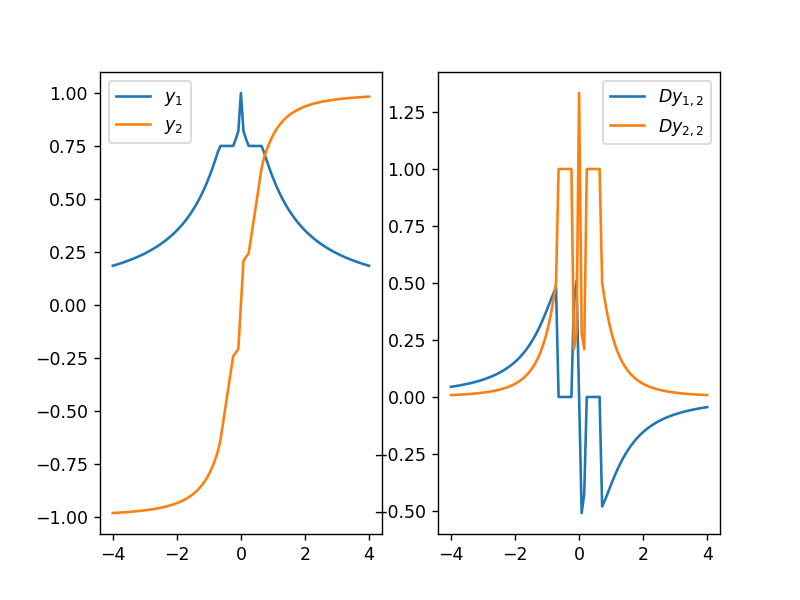

In [14]:
def gradient(x, y):
    # compute D_Y f(x, y)
    g = (y - x).T
    
    def Dy_for_h1_active():
        A = 2.0 * y.T
        lmda1 = g[0] / A[0]
        Dy = np.identity(2) - np.outer(A.T, A) / np.dot(A, A.T)
        return 1.0 / (1.0 - 2.0 * lmda1) * Dy

    def Dy_for_h2_active():
        A = np.array([-0.5 * (y[0] + 1.0), -8.0 * y[1]])
        lmda2 = g[0] / A[0]
        invH = np.array([[1.0 / (1.0 + 0.5 * lmda2), 0.0], [0.0, 1.0 / (1.0 + 8.0 * lmda2)]])
        Dy = -1.0 * np.outer(np.dot(invH, A), np.dot(A.T, invH)) / np.dot(A.T, np.dot(invH, A)) + invH
        return Dy
    
    # compute gradient depending on which constraints are active
    if h1(y) < eps and h2(y) < eps:
        h1_YY = 2.0 * np.identity(2)
        h2_YY = np.array([[-0.5, 0.0], [0.0, -8.0]])
        v1 = np.dot(np.linalg.solve(h1_YY, g), g)
        v2 = np.dot(np.linalg.solve(h2_YY, g), g)
        if v1 > v2:
            return Dy_for_h1_active()
        else:
            return Dy_for_h2_active()
        
    if h1(y) < eps:
        return Dy_for_h1_active()
        
    if h2(y) < eps:
        return Dy_for_h2_active()
            
    # no active constraints
    return np.identity(2)


dydx = []
for xi, yi in zip(x2, y):
    Dy = gradient((x1, xi), yi)
    dydx.append(Dy[1, :])
    
# plot y and Dy
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(x2, [yi[0] for yi in y])
plt.plot(x2, [yi[1] for yi in y])
plt.legend([r"$y_1$", r"$y_2$"])

plt.subplot(1, 2, 2)
# computed gradient
plt.plot(x2, [di[0] for di in dydx])
plt.plot(x2, [di[1] for di in dydx])
# check against empirical gradient
#plt.plot(x2, np.gradient([yi[0] for yi in y], (x2[-1] - x2[0]) / (len(x2) - 1)))
#plt.plot(x2, np.gradient([yi[1] for yi in y], (x2[-1] - x2[0]) / (len(x2) - 1)))
plt.legend([r"$D y_{1,2}$", r"$D y_{2,2}$", r"$D^\star y_{1,2}$", r"$D^\star y_{2,2}$"])
plt.show()